# Chapter 5 — Dataset Construction and Splitting

In this notebook, we explore how raw image data becomes a structured dataset suitable for training computer vision models.

We will:
- Load an existing dataset (tf_flowers)
- Inspect class balance
- Create reproducible train/validation/test splits
- Build a tf.data pipeline
- Discuss data leakage


In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

print("TensorFlow version:", tf.__version__)

# Load Dataset + Info from TFDS

dataset, info = tfds.load(
    "tf_flowers",
    with_info=True,
    as_supervised=True
)

print(info)



TensorFlow version: 2.9.1
tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='C:\\Users\\Jason Eckert\\tensorflow_datasets\\tf_flowers\\3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)


In [6]:
# Inspect Class Distribution

train_ds = dataset["train"]

class_counts = {}

for _, label in tfds.as_numpy(train_ds):
    class_counts[label] = class_counts.get(label, 0) + 1

for label, count in class_counts.items():
    print(info.features["label"].int2str(label), ":", count)


tulips : 799
sunflowers : 699
roses : 641
dandelion : 898
daisy : 633


In [7]:
# Build tf.data Pipeline Using TFDS Native Splits 

# Preparation

IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Load dataset with deterministic splits
(train_raw, val_raw, test_raw), info = tfds.load(
    "tf_flowers",
    split=[
        "train[:70%]",      # 70% training
        "train[70%:85%]",   # 15% validation
        "train[85%:]"       # 15% testing
    ],
    as_supervised=True,
    with_info=True
)

print("Class names:", info.features["label"].names)
print("Number of classes:", info.features["label"].num_classes)


# Preprocessing Function

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label


# Build Optimized Pipelines

train_ds = (
    train_raw
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_ds = (
    val_raw
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_ds = (
    test_raw
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)


print("Training batches:", tf.data.experimental.cardinality(train_ds))
print("Validation batches:", tf.data.experimental.cardinality(val_ds))
print("Test batches:", tf.data.experimental.cardinality(test_ds))



Class names: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
Number of classes: 5
Training batches: tf.Tensor(81, shape=(), dtype=int64)
Validation batches: tf.Tensor(18, shape=(), dtype=int64)
Test batches: tf.Tensor(18, shape=(), dtype=int64)


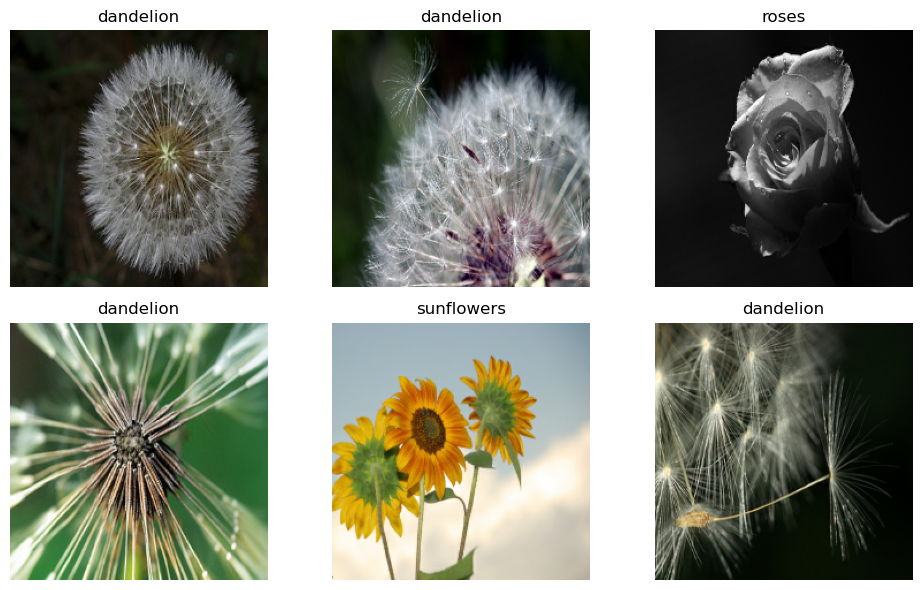

In [8]:
# Visualize Batch

images, labels = next(iter(train_ds))

plt.figure(figsize=(10,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i])
    plt.title(info.features["label"].int2str(int(labels[i])))
    plt.axis("off")
plt.tight_layout()
plt.show()


### Key Takeaways

- Dataset design influences model performance.
- Splitting must be reproducible.
- Stratification prevents label imbalance.
- tf.data pipelines are scalable abstractions.
